# Kendall's τ of spatial covariance

## Packages

## Variables to be defined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import matplotlib.ticker as mticker

import xarray as xr
import cartopy.feature as cf

from figure_params import *

# Load data

In [2]:
amazon_basin = xr.open_dataarray('data/amazon_basin_mask.nc') #http://worldmap. harvard.edu/data/geonode:amapoly_ivb

data = xr.Dataset({
    "AMSR-E band C\n2002-2011": xr.open_dataarray("data/csd_trends_AMSRE_bandC.nc"),
    "AMSR-E band X\n2002-2011": xr.open_dataarray("data/csd_trends_AMSRE_bandX.nc"),
    "AMSR2 band C1\n2012-2020": xr.open_dataarray("data/csd_trends_AMSR2_bandC1.nc"),
    "AMSR2 band C2\n2012-2020": xr.open_dataarray("data/csd_trends_AMSR2_bandC2.nc")
}).to_array("VI")

/home/lanabl/.conda/envs/env23/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
module 'contextlib' has no attribute 'nullcontext'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Figure functions

In [3]:
nbins = 31
ncol = 3
nrow = 4

bbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)


def set_hist_colors(bins, patches, scalarMap):
    bin_centers = 0.5*(bins[:-1]+bins[1:])
    for c, p in zip(bin_centers, patches): plt.setp(p, "facecolor", scalarMap.to_rgba(c))

    
# Maximum value on the color scale
def get_scaled_colormap(vmax):
    cNorm = Normalize(vmin=-vmax, vmax=vmax)
    return plt.cm.ScalarMappable(norm=cNorm, cmap=cmap_trends)


def configure_axis(axis, xmax=None):
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0,0))
    if xmax != None: axis.set_xlim(-xmax, xmax)
    axis.locator_params(axis='x', nbins=5, tight=True)
    axis.set_title("")
    axis.yaxis.tick_right()
    axis.xaxis.set_major_formatter(formatter)
    axis.spines["left"].set_alpha(0.)
    axis.spines["top" ].set_alpha(0.)
    axis.patch.set_alpha(0.)
    xticks = axis.get_xticks()
    axis.set_xticks(xticks[[0, len(xticks)//2, -1]])
    axis.set_yticks([axis.get_yticks()[-2]])


def plot_map(data, axis, vmax):
    p = data.plot(x="lon", transform=transform_data, ax=axis, cmap=cmap_trends, vmin=-vmax, vmax=vmax, add_colorbar=False)
    amazon_basin.where(amazon_basin).plot(ax=axis, transform=transform_data, cmap=cmap_nan, zorder=0, add_colorbar=False)
    amazon_basin.plot.contour(ax=axis, transform=transform_data, cmap="k", zorder=0)

    axis.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', zorder=0, facecolor=color_land, alpha=.4))
    axis.add_feature(cf.BORDERS)
    
    # # make map prettier
    axis.set_extent(map_extent)
    axis.axis("off")
    return p


def add_hist(fig, data, axis, vmax=None):
    poswidth = .08
    axbox = axis.get_position()
        
    axisTab = fig.add_axes([axbox.x1-poswidth, axbox.y0+.001, poswidth, .06])

    bins = np.linspace(-vmax, vmax, nbins+1)
    n, b, p = data.plot.hist(ax=axisTab, color="r", bins=bins, edgecolor="k")

    set_hist_colors(b,p,get_scaled_colormap(vmax))
    # 0-line
    y_0 = np.minimum(n[np.where(b<0)[0][-1]], n[np.where(b<0)[0][-1]+1]) / axisTab.get_ylim()[1] # height of hist at the 0
    axisTab.axvline(0, ymax=y_0, lw=3, color = "k")

    # median-line
    y_median = n[np.where(b<data.median().values)[0][-1]]/axisTab.get_ylim()[1] # height of hist at the location of median
    axisTab.axvline(data.median(), ymax=y_median, lw=3, color = c_orange)

    # print percentages of pos/neg trends
    nCtotal = data.notnull().sum().values/100.
    axisTab.text(x=axisTab.get_xlim()[0]*.8, y=np.mean(axisTab.get_ylim())*.5, s="%3.1f%%"%((data<0).sum().values/nCtotal), ha="left", va="center", fontsize=18, bbox=bbox_props)
    axisTab.text(x=axisTab.get_xlim()[1]*.8, y=np.mean(axisTab.get_ylim())*.5, s="%3.1f%%"%((data>0).sum().values/nCtotal), ha="right", va="center", fontsize=18, bbox=bbox_props)
    configure_axis(axisTab, xmax=vmax)
    


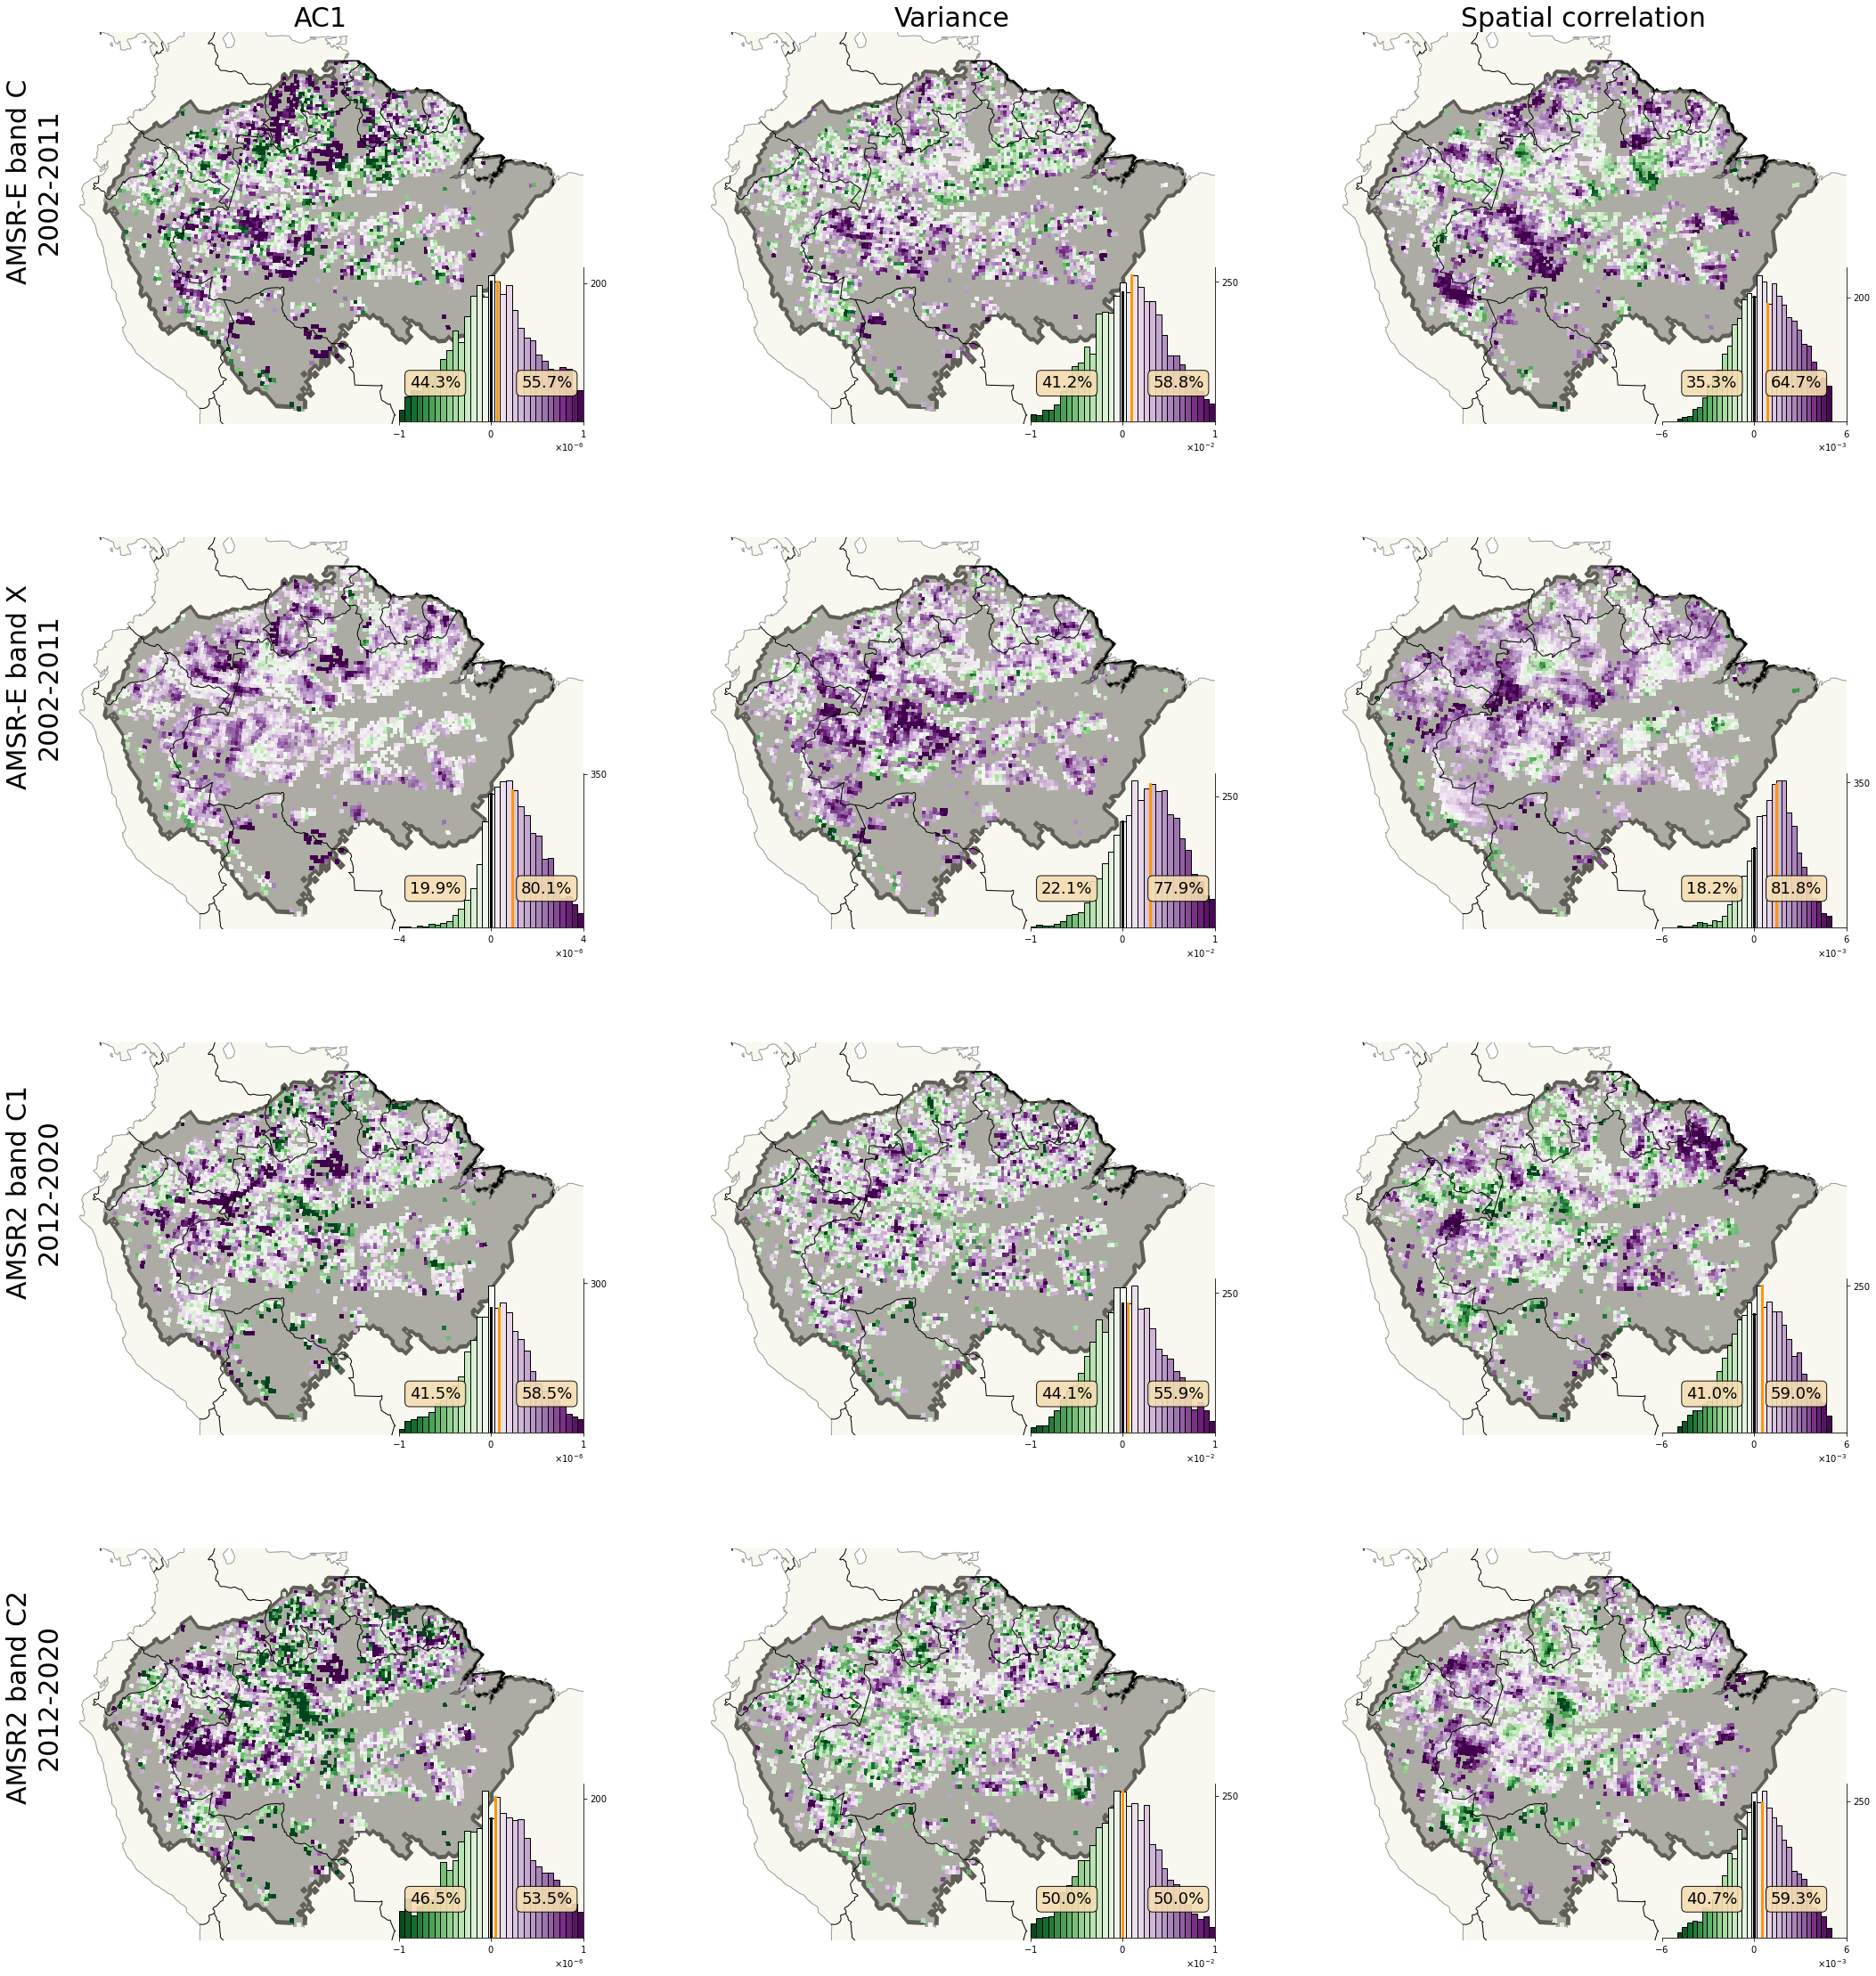

In [4]:

# fig, axes = plt.subplots(nrow, ncol, figsize = (ncol*12, nrow*10), subplot_kw=subplot_kws)#, gridspec_kw=dict(wspace=.05, hspace=.1))
fig, axes = plt.subplots(nrow, ncol, figsize = (ncol*12, nrow*10), subplot_kw=subplot_kws)

d = data.sel(indicator="Variance", drop=True)
ax = axes[:, 0]
for a, vi, vmax in zip(ax, d.VI.values, [1e-6, 4e-6, 1e-6, 1e-6]):
    p = plot_map(d.sel(VI=vi), axis=a, vmax=vmax)
    add_hist(fig, d.sel(VI=vi), axis=a, vmax=vmax)

d = data.sel(indicator="AC1", drop=True)
ax = axes[:, 1]
vmax = 1e-2
for a, vi in zip(ax, d.VI.values):
    p = plot_map(d.sel(VI=vi), axis=a, vmax=vmax)
    add_hist(fig, d.sel(VI=vi), axis=a, vmax=vmax)

d = data.sel(indicator="SpatialCorrelation", drop=True)
ax = axes[:, 2]
vmax=5e-3
for a, vi in zip(ax, d.VI.values):
    p = plot_map(d.sel(VI=vi), axis=a, vmax=vmax)
    add_hist(fig, d.sel(VI=vi), axis=a, vmax=vmax)


# TITLES
for a, vi in zip(axes[:,0], data.VI.values): a.text(-85,-5, vi, {'ha': 'center', 'va': 'center', 'rotation':90, 'size':30}, transform=transform_data)
for a, indicator in zip(axes[0,:], data.indicator.values): a.set_title(indicator.replace("lC", "l c"), fontsize=30)